# Setup

In [1]:
!git clone https://github.com/jjordanoc/Pi3.git
%cd Pi3
%uv pip install -r requirements.txt

Cloning into 'Pi3'...
remote: Enumerating objects: 157, done.
remote: Counting objects: 100% (157/157), done.
remote: Compressing objects: 100% (137/137), done.
remote: Total 157 (delta 35), reused 138 (delta 19), pack-reused 0 (from 0)
Receiving objects: 100% (157/157), 36.80 MiB | 37.31 MiB/s, done.
Resolving deltas: 100% (35/35), done.
/root/Pi3


/usr/local/lib/python3.10/site-packages/IPython/core/magics/osm.py:417: UserWarning: This is now an optional IPython functionality, setting dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


Using Python 3.10.15 environment at: /usr/local
Resolved 38 packages in 296ms                                        
Prepared 28 packages in 51.07s                                           
Installed 28 packages in 950ms                              
 + filelock==3.19.1
 + fsspec==2025.7.0
 + hf-xet==1.1.8
 + huggingface-hub==0.34.4
 + mpmath==1.3.0
 + networkx==3.4.2
 + numpy==1.26.4
 + nvidia-cublas-cu12==12.4.5.8
 + nvidia-cuda-cupti-cu12==12.4.127
 + nvidia-cuda-nvrtc-cu12==12.4.127
 + nvidia-cuda-runtime-cu12==12.4.127
 + nvidia-cudnn-cu12==9.1.0.70
 + nvidia-cufft-cu12==11.2.1.3
 + nvidia-curand-cu12==10.3.5.147
 + nvidia-cusolver-cu12==11.6.1.9
 + nvidia-cusparse-cu12==12.3.1.170
 + nvidia-nccl-cu12==2.21.5
 + nvidia-nvjitlink-cu12==12.4.127
 + nvidia-nvtx-cu12==12.4.127
 + opencv-python==4.11.0.86
 + pillow==11.3.0
 + plyfile==1.1.2
 + safetensors==0.6.2
 + sympy==1.13.1
 + torch==2.5.1
 + torchvision==0.20.1
 + tqdm==4.67.1
 + triton==3.1.0
Note: you may need to restart the 

In [2]:
%uv pip install datasets lpips jaxtyping scipy matplotlib hf_transfer

Using Python 3.10.15 environment at: /usr/local
Resolved 64 packages in 409ms                                        
Prepared 20 packages in 2.87s                                            
Uninstalled 1 package in 2ms
Installed 20 packages in 395ms                              
 + contourpy==1.3.2
 + cycler==0.12.1
 + datasets==4.0.0
 + dill==0.3.8
 + fonttools==4.59.1
 - fsspec==2025.7.0
 + fsspec==2025.3.0
 + hf-transfer==0.1.9
 + jaxtyping==0.3.2
 + kiwisolver==1.4.9
 + lpips==0.1.4
 + matplotlib==3.10.5
 + multiprocess==0.70.16
 + pandas==2.3.2
 + pyarrow==21.0.0
 + pyparsing==3.2.3
 + pytz==2025.2
 + scipy==1.15.3
 + tzdata==2025.2
 + wadler-lindig==0.1.7
 + xxhash==3.5.0
Note: you may need to restart the kernel to use updated packages.


In [3]:
import os

# Define the directory inside your mounted Volume
save_dir = "/mnt/perceptual-eval"
os.makedirs(save_dir, exist_ok=True) # Create the directory if it doesn't exist

In [4]:
from huggingface_hub import snapshot_download
snapshot_download("yyfz233/Pi3", cache_dir="/mnt/perceptual-eval")

.gitattributes: 0.00B [00:00, ?B/s]

README.md: 0.00B [00:00, ?B/s]

config.json:   0%|          | 0.00/54.0 [00:00<?, ?B/s]

main.png:   0%|          | 0.00/1.10M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/3.83G [00:00<?, ?B/s]

'/mnt/perceptual-eval/models--yyfz233--Pi3/snapshots/ae722e7039287d0c8fde9f11f197f804f44b510c'

In [5]:
from datasets import load_dataset

# download huggingface dataset 
benchmark = load_dataset("tzler/MOCHI")['train']

# there are 2019 trials let's pick one 
trial_subset_idx = [0, 1879, 1000, 500, 2009, 120, 423, 100, 800, 900]
trial_subset = benchmark.select(trial_subset_idx)
trial_subset

README.md: 0.00B [00:00, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/383M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/2019 [00:00<?, ? examples/s]

Dataset({
    features: ['dataset', 'condition', 'trial', 'n_objects', 'oddity_index', 'images', 'n_subjects', 'human_avg', 'human_sem', 'human_std', 'RT_avg', 'RT_sem', 'RT_std', 'DINOv2G_avg', 'DINOv2G_std', 'DINOv2G_sem'],
    num_rows: 10
})

In [6]:
import matplotlib.pyplot as plt
def plot_trial(i_trial):
    plt.figure(figsize=[15,4])
    for i_plot in range(len(i_trial['images'])):
      plt.subplot(1,len(i_trial['images']),i_plot+1)
      plt.imshow(i_trial['images'][i_plot])
      if i_plot == i_trial['oddity_index']: plt.title('odd-one-out')
      plt.axis('off')
    plt.show()

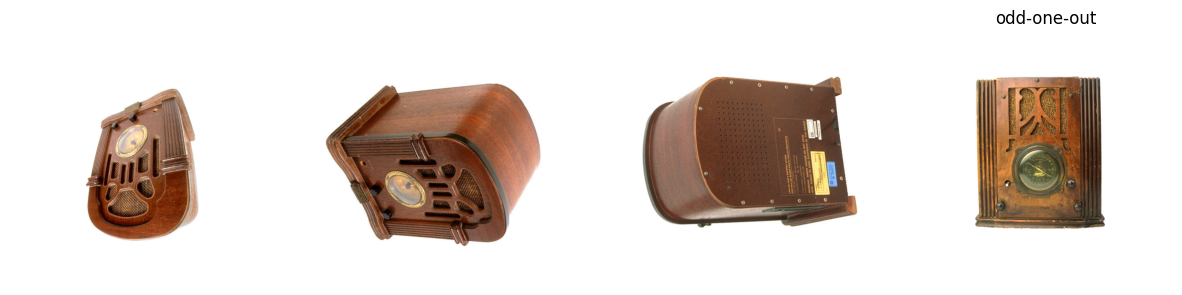

In [7]:
plot_trial(trial_subset[0])

In [8]:
from typing import List
from PIL import Image
import torch
from torchvision import transforms
import math
from typing import List

def pil_list_to_tensor(sources: List[Image.Image]) -> torch.Tensor:
    """Extracted from PI3 source"""
    PIXEL_LIMIT=255000
    if not sources:
        print("No images found or loaded.")
        return torch.empty(0)

    # print(f"Found {len(sources)} images/frames. Processing...")

    # --- 2. Determine a uniform target size for all images based on the first image ---
    # This is necessary to ensure all tensors have the same dimensions for stacking.
    first_img = sources[0]
    W_orig, H_orig = first_img.size
    scale = math.sqrt(PIXEL_LIMIT / (W_orig * H_orig)) if W_orig * H_orig > 0 else 1
    W_target, H_target = W_orig * scale, H_orig * scale
    k, m = round(W_target / 14), round(H_target / 14)
    while (k * 14) * (m * 14) > PIXEL_LIMIT:
        if k / m > W_target / H_target: k -= 1
        else: m -= 1
    TARGET_W, TARGET_H = max(1, k) * 14, max(1, m) * 14
    print(f"All images will be resized to a uniform size: ({TARGET_W}, {TARGET_H})")

    # --- 3. Resize images and convert them to tensors in the [0, 1] range ---
    tensor_list = []
    # Define a transform to convert a PIL Image to a CxHxW tensor and normalize to [0,1]
    to_tensor_transform = transforms.ToTensor()
    
    for img_pil in sources:
        try:
            # Resize to the uniform target size
            resized_img = img_pil.resize((TARGET_W, TARGET_H), Image.Resampling.LANCZOS)
            # Convert to tensor
            img_tensor = to_tensor_transform(resized_img)
            tensor_list.append(img_tensor)
        except Exception as e:
            print(f"Error processing an image: {e}")

    if not tensor_list:
        print("No images were successfully processed.")
        return torch.empty(0)

    # --- 4. Stack the list of tensors into a single [N, C, H, W] batch tensor ---
    return torch.stack(tensor_list, dim=0)

def mochi_to_batch_list(subset) -> List[torch.Tensor]:
    batch_list = []
    for i_trial in subset:
        batch_list.append(pil_list_to_tensor(i_trial['images']))
    return batch_list

# Model and dataset setup

In [9]:
import torch
from pi3.models.pi3 import Pi3

# --- Setup ---
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model = Pi3.from_pretrained("yyfz233/Pi3").to(device).eval()

Warning, cannot find cuda-compiled version of RoPE2D, using a slow pytorch version instead


config.json:   0%|          | 0.00/54.0 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/3.83G [00:00<?, ?B/s]

In [10]:
import matplotlib.pyplot as plt

# --- Load Data ---
# Load a sequence of N images into a tensor
# imgs shape: (N, 3, H, W).
# imgs value: [0, 1]
preprocessed_data = mochi_to_batch_list(trial_subset)
imgs = [t.to(device) for t in preprocessed_data]

# (#samples, #channels, H, W)
imgs[0].shape

All images will be resized to a uniform size: (504, 504)
All images will be resized to a uniform size: (504, 504)
All images will be resized to a uniform size: (504, 504)
All images will be resized to a uniform size: (504, 504)
All images will be resized to a uniform size: (504, 504)
All images will be resized to a uniform size: (504, 504)
All images will be resized to a uniform size: (504, 504)
All images will be resized to a uniform size: (504, 504)
All images will be resized to a uniform size: (504, 504)
All images will be resized to a uniform size: (504, 504)


torch.Size([4, 3, 504, 504])

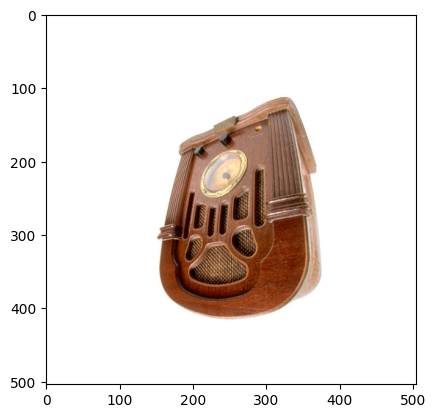

In [11]:
plt.imshow(imgs[0][0].permute(1, 2, 0).cpu().numpy())

In [12]:
class FeatureCapture:
    def __init__(self, model, targets, mode="input"):
        self.model = model
        self.targets = targets
        self.mode = mode
        self.feats = {}
        self.handles = []

    @staticmethod
    def _prehook(store, alias):
        # pre-hook: receives (mod, inp) - 2 arguments
        def fn(mod, inp):
            store[alias] = inp[0].detach()
        return fn

    @staticmethod
    def _fwdhook(store, alias):
        # forward-hook: receives (mod, inp, out) - 3 arguments  
        def fn(mod, inp, out):
            store[alias] = out.detach()
        return fn

    def start(self):
        self.stop()
        self.feats.clear()
        for alias, m in self.targets.items():
            if m is None:
                raise ValueError(f"Target module for {alias} is None")
            if self.mode == "input":
                # Use _prehook for input capture
                self.handles.append(m.register_forward_pre_hook(self._prehook(self.feats, alias)))
            else:
                # Use _fwdhook for output capture
                self.handles.append(m.register_forward_hook(self._fwdhook(self.feats, alias)))

    def stop(self):
        for h in self.handles:
            h.remove()
        self.handles = []


In [13]:
from typing import List, Tuple
def pi3_inference_capture(model, img_tensor_list: List[torch.Tensor]) -> Tuple[List[torch.Tensor], List[torch.Tensor]]:
    # Capture features
    caps = FeatureCapture(model, {
        "hidden_features": model.point_decoder,
    }, mode="input")


    # --- Inference ---
    print("Running model inference...")
    # Use mixed precision for better performance on compatible GPUs
    dtype = torch.bfloat16 if torch.cuda.is_available() and torch.cuda.get_device_capability()[0] >= 8 else torch.float16
    
    
    caps_feat_list = []
    results_batch_list = []
    with torch.no_grad():
        with torch.amp.autocast('cuda', dtype=dtype):
            # Process as separate batches
            for batch in img_tensor_list:
                caps.start()
                results = model(batch)
                results_batch_list.append(results)
                caps_feat_list.append(caps.feats["hidden_features"].clone())
                caps.stop()
    
    print("Reconstruction complete!")
    # Access outputs: results['points'], results['camera_poses'] and results['local_points'].
    return results_batch_list, caps_feat_list

# Embedding analysis

## Single image to VGGT embedding

In [20]:
single_image_list = [t[:, None] for t in imgs]
single_image_list[0].shape

torch.Size([4, 1, 3, 504, 504])

In [21]:
results, caps = pi3_inference_capture(model, img_tensor_list=single_image_list)

Running model inference...
Reconstruction complete!


In [22]:
caps[0].shape

torch.Size([4, 1301, 2048])

In [23]:
results[0]["camera_poses"].shape

torch.Size([4, 1, 4, 4])

In [24]:
results[0]["points"].shape

torch.Size([4, 1, 504, 504, 3])

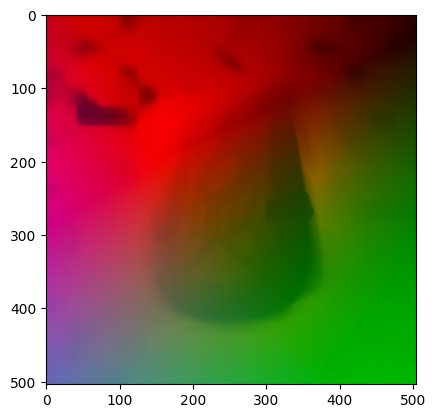

In [25]:
# image_mean = torch.tensor([0.485, 0.456, 0.406]).view(1, 1, 3)
# image_std  = torch.tensor([0.229, 0.224, 0.225]).view(1, 1, 3)

# ex_map = results["points"][0][0].cpu() * image_std + image_mean
ex_map = results[0]["points"][0][0].cpu()
plt.imshow(ex_map.numpy().clip(0, 1))

In [ ]:
caps[0].shape

torch.Size([4, 1301, 2048])

In [27]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from matplotlib import gridspec
from scipy.spatial.distance import squareform, pdist
import numpy as np

def plot_distance_matrix_with_images(embeddings, image_tensors, oddity_index=None, trial_n=-1, metric='cosine', cmap="magma"):
    """
    Plot distance matrix with images displayed along the top (x-axis) and left (y-axis).
    
    Args:
        embeddings: (N, D) embeddings of dimension D
        image_tensors: list of images (H, W, 3)
        oddity_index: index of the oddity image to highlight (optional)
        trial_n: integer trial number
        metric: distance metric
    """
    pooled_features = embeddings.cpu().numpy()
    distance_matrix = squareform(pdist(pooled_features, metric=metric))
    
    n_imgs = len(image_tensors)
    fig = plt.figure(figsize=(2+n_imgs, 2+n_imgs))

    gs = gridspec.GridSpec(
        n_imgs+1, n_imgs+1, figure=fig,
        width_ratios=[4] + [4]*n_imgs,
        height_ratios=[4] + [4]*n_imgs
    )
    
    # main matrix
    ax_matrix = fig.add_subplot(gs[1:, 1:])
    cax = ax_matrix.matshow(distance_matrix, cmap=cmap, vmin=0, vmax=1.0 if metric == 'cosine' else None)
    fig.colorbar(cax, ax=ax_matrix, fraction=0.046, pad=0.04)

    ax_matrix.set_xticks(np.arange(n_imgs))
    ax_matrix.set_yticks(np.arange(n_imgs))
    ax_matrix.set_xticklabels([])
    ax_matrix.set_yticklabels([])

    # top row (x-axis images)
    for j in range(n_imgs):
        ax = fig.add_subplot(gs[0, j+1])
        ax.imshow(image_tensors[j])
        ax.axis("off")
        
        # Add red border if this is the oddity
        if oddity_index is not None and j == oddity_index:
            rect = patches.Rectangle((0, 0), 1, 1, linewidth=5, edgecolor='red', 
                                   facecolor='none', transform=ax.transAxes, clip_on=False)
            ax.add_patch(rect)

    # left column (y-axis images)
    for i in range(n_imgs):
        ax = fig.add_subplot(gs[i+1, 0])
        ax.imshow(image_tensors[i])
        ax.axis("off")
        
        # Add red border if this is the oddity
        if oddity_index is not None and i == oddity_index:
            rect = patches.Rectangle((0, 0), 1, 1, linewidth=5, edgecolor='red', 
                                   facecolor='none', transform=ax.transAxes, clip_on=False)
            ax.add_patch(rect)
    
    # Annotate distances inside the matrix
    for i in range(n_imgs):
        for j in range(n_imgs):
            color = "white" if distance_matrix[i, j] <= distance_matrix.max()/2 else "black"
            ax_matrix.text(j, i, f"{distance_matrix[i, j]:.2f}",
                           ha="center", va="center", color=color, fontsize=8)

    # Add global title with oddity info
    title = f"Trial {trial_n}, metric = {metric}"
    if oddity_index is not None:
        title += f" (Oddity: Image {oddity_index})"
    fig.suptitle(title, fontsize=14, fontweight="bold", y=1.02)

    plt.tight_layout()
    return fig, distance_matrix

In [28]:
import numpy as np

def oddity_from_matrix(distance_matrix):
    """
    Given a pairwise distance matrix, identify the oddity as the item
    with the highest average distance to all other items.
    
    Args:
        distance_matrix: numpy array of shape (N, N), symmetric with zeros on diagonal
        
    Returns:
        oddity_index: int, index of the odd one out
        mean_distances: array of mean distances for each item
    """
    n = distance_matrix.shape[0]
    
    # Ensure diagonal is zero (self-distances)
    distance_matrix = distance_matrix.copy()
    np.fill_diagonal(distance_matrix, 0)
    
    # Compute mean off-diagonal distance for each item
    mean_distances = distance_matrix.sum(axis=1) / (n - 1)
    
    # Oddity = item with HIGHEST average distance (lowest similarity)
    oddity_index = np.argmax(mean_distances)
    
    return oddity_index

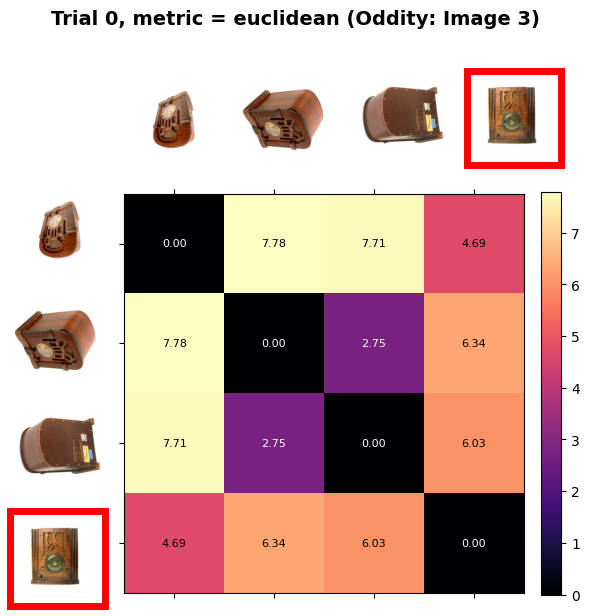

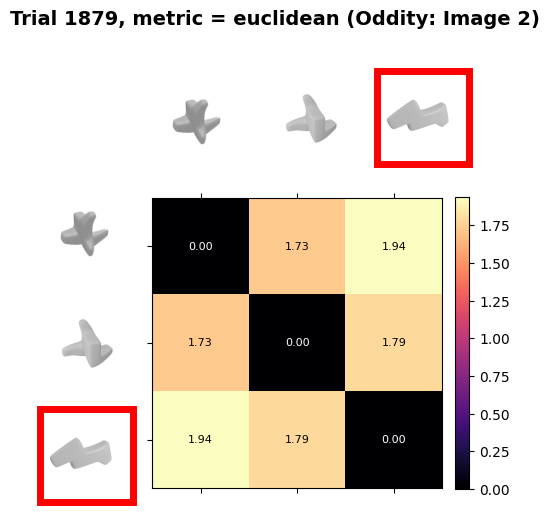

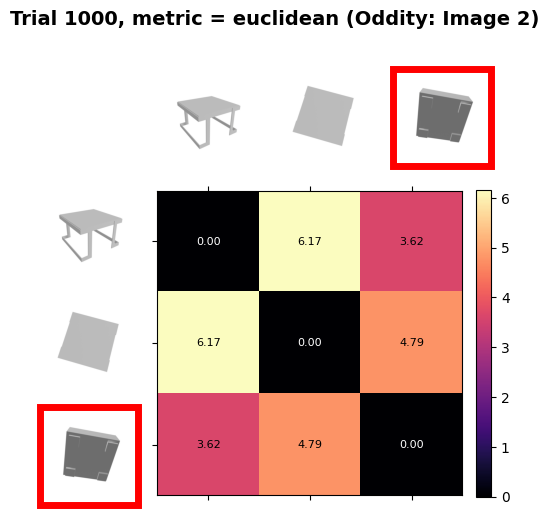

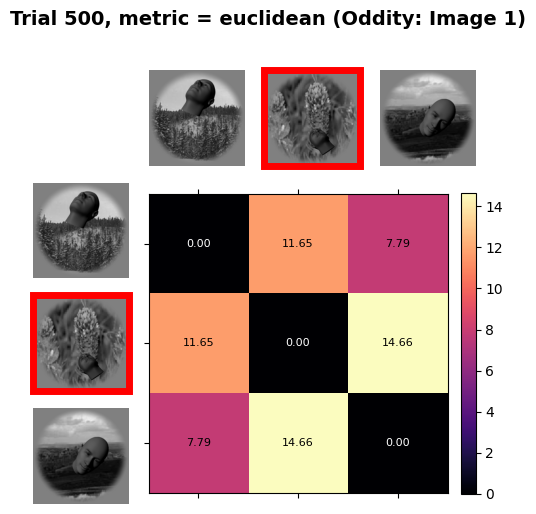

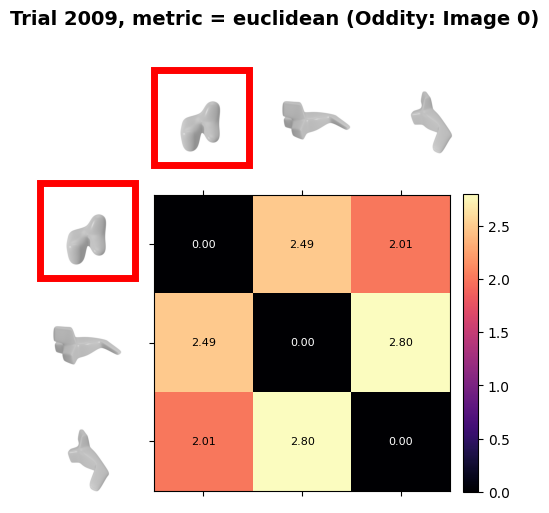

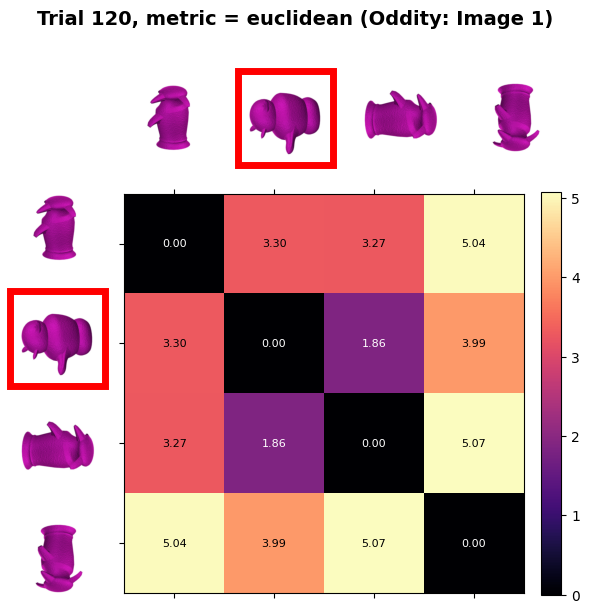

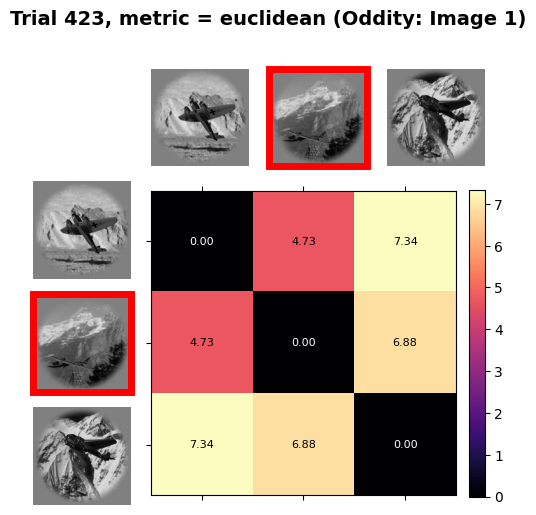

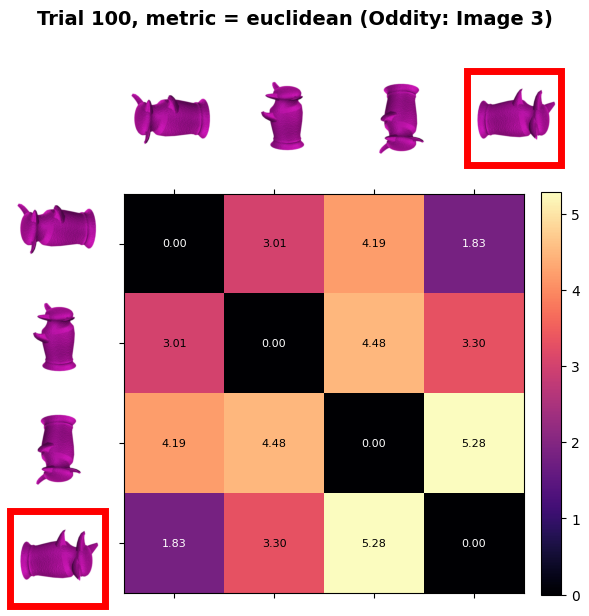

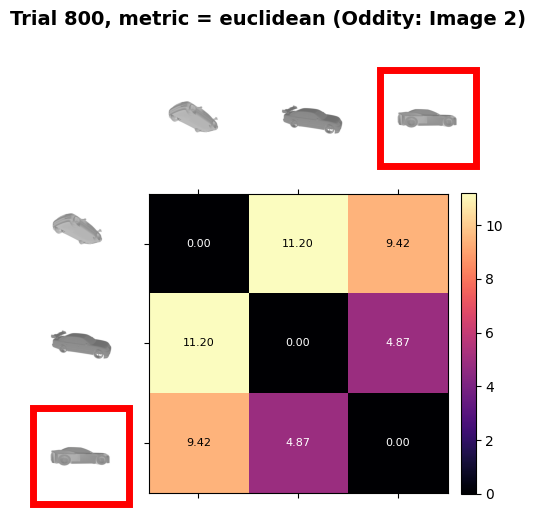

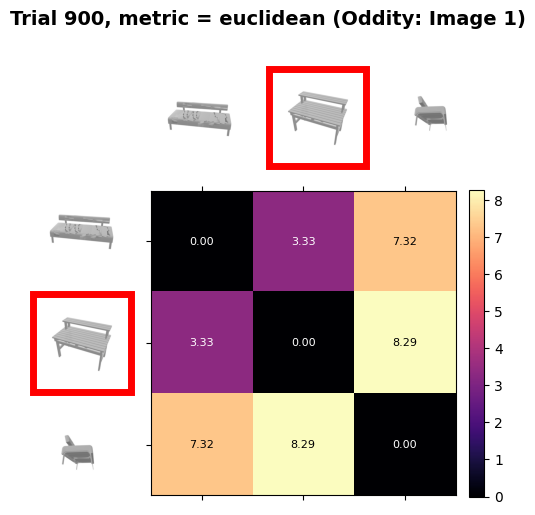

In [29]:
# drop the 5 tokens (image + camera tokens) → pool the rest
pred_oddities = []
for i in range(len(trial_subset_idx)):
    pi3_embeddings = caps[i][:, 5:, :].mean(dim=1)
    fig, distances = plot_distance_matrix_with_images(pi3_embeddings, trial_subset[i]["images"], metric="euclidean", trial_n=trial_subset_idx[i], oddity_index=trial_subset[i]["oddity_index"])
    pred_oddity = oddity_from_matrix(distances)
    pred_oddities.append(pred_oddity)

In [30]:
pred_oddities

[0, 2, 1, 1, 1, 3, 2, 2, 0, 2]

In [31]:
accuracy = [pred_oddities[i] == trial_subset[i]["oddity_index"] for i in range(len(pred_oddities))]
accuracy = sum(accuracy) / len(accuracy)
accuracy

0.2

## Left-out VGGT embeddings

In [14]:
import torch
from itertools import combinations

# imgs: (K, C, H, W) tensor
left_out_batches = []
single_left_out_batches = []
for t in imgs:
    K = t.shape[0]
    
    # Get all combinations of K-1 images (leaving 1 out each time)
    # Form batches of shape (K, K-1, C, H, W), such that each batch has one image left out
    # Left out batches should be (K, 1, C, H, W)
    batch_tensor = torch.zeros(K, K-1, t.shape[1], t.shape[2], t.shape[3]).to(t.device)
    left_out_tensor = torch.zeros(K, 1, t.shape[1], t.shape[2], t.shape[3]).to(t.device)
    for leave_out in range(K):
        combo = [i for i in range(K) if i != leave_out]
        batch = t[combo].unsqueeze(0)
        batch_tensor[leave_out] = batch
        left_out_tensor[leave_out] = t[leave_out].unsqueeze(0)
    left_out_batches.append(batch_tensor)
    single_left_out_batches.append(left_out_tensor)



In [15]:
left_out_batches[0].shape

torch.Size([4, 3, 3, 504, 504])

In [16]:
single_left_out_batches[0].shape

torch.Size([4, 1, 3, 504, 504])

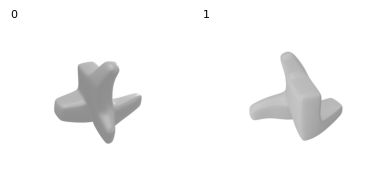

In [35]:
# plot all left out images for a batch
fig, axes = plt.subplots(1, 2, figsize=(4, 12))
# Plot each image with a unique index on the bottom-right corner
for ax, img, idx in zip(axes.flat, left_out_batches[1][2], range(len(left_out_batches[1][2]))):
    ax.imshow(img.permute(1, 2, 0).cpu().numpy())
    ax.axis('off')
    ax.text(1, -0.5, f'{idx}', fontsize=8, ha='right', va='top')

plt.tight_layout()
plt.show()

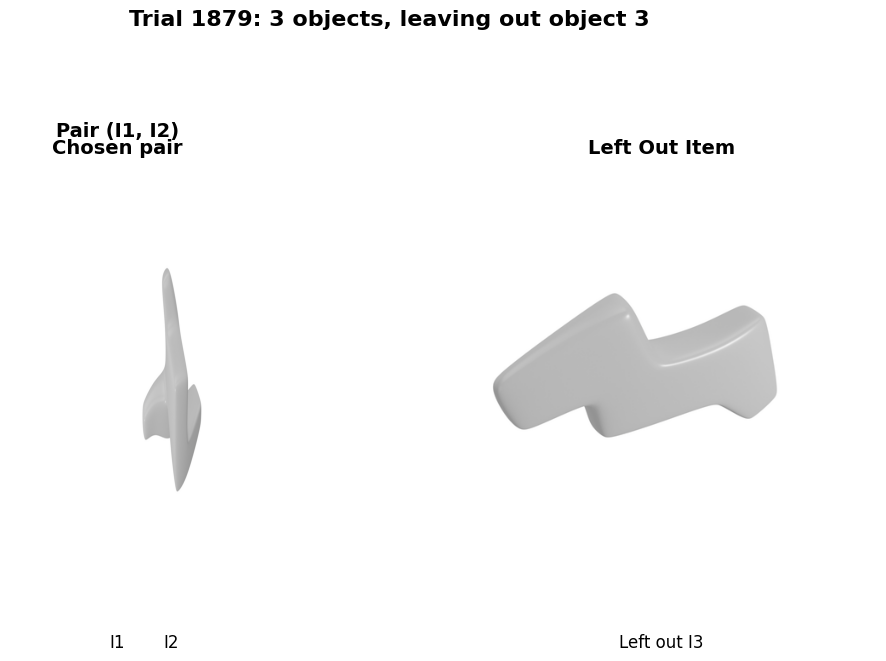

In [40]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches

def visualize_pairs_and_left_out(trial_idx=0, batch_idx=0):
    """
    Visualize the chosen pairs/triplets (left) and the left out item (right)
    
    Args:
        trial_idx: index of the trial to visualize
        batch_idx: index of which left-out scenario to show (0 to K-1)
    """
    # Get the current trial data
    trial = trial_subset[trial_idx]
    n_objects = trial["n_objects"]
    
    # Get the chosen pairs/triplets (all images except the left out one)
    chosen_images = left_out_batches[trial_idx][batch_idx]  # Shape: (K-1, C, H, W)
    
    # Get the left out image
    left_out_image = single_left_out_batches[trial_idx][batch_idx]  # Shape: (1, C, H, W)
    
    # Create the visualization
    fig, (ax_left, ax_right) = plt.subplots(1, 2, figsize=(12, 6))
    
    # Left side: Show chosen pairs/triplets
    ax_left.set_title(f"Chosen {'pair' if n_objects == 3 else 'triplet'}", fontsize=14, fontweight='bold')
    
    # For 3 objects: show 2 images side by side
    # For 4+ objects: show in a grid
    if n_objects == 3:
        # Show 2 images side by side
        ax_left.imshow(chosen_images[0].permute(1, 2, 0).cpu().numpy())
        ax_left.axis('off')
        ax_left.text(0.5, -0.1, f'I1', ha='center', va='top', transform=ax_left.transAxes, fontsize=12)
        
        # Add second image
        ax_left.imshow(chosen_images[1].permute(1, 2, 0).cpu().numpy(), 
                      extent=[0.5, 1, 0, 1], transform=ax_left.transAxes)
        ax_left.text(0.75, -0.1, f'I2', ha='center', va='top', transform=ax_left.transAxes, fontsize=12)
        
        # Add label for the pair
        ax_left.text(0.5, 1.05, f'Pair (I1, I2)', ha='center', va='bottom', 
                    transform=ax_left.transAxes, fontsize=14, fontweight='bold')
        
    else:
        # For 4+ objects, show in a grid
        n_chosen = chosen_images.shape[0]
        cols = min(3, n_chosen)
        rows = (n_chosen + cols - 1) // cols
        
        for i in range(n_chosen):
            row = i // cols
            col = i % cols
            x_start = col / cols
            y_start = 1 - (row + 1) / rows
            x_end = (col + 1) / cols
            y_end = 1 - row / rows
            
            ax_left.imshow(chosen_images[i].permute(1, 2, 0).cpu().numpy(),
                          extent=[x_start, x_end, y_start, y_end], transform=ax_left.transAxes)
            
            # Add index label
            ax_left.text((x_start + x_end) / 2, y_start - 0.05, f'I{i+1}', 
                        ha='center', va='top', transform=ax_left.transAxes, fontsize=10)
        
        ax_left.axis('off')
        ax_left.text(0.5, 1.05, f'Triplet (I1, I2, I3...)', ha='center', va='bottom', 
                    transform=ax_left.transAxes, fontsize=14, fontweight='bold')
    
    # Right side: Show left out item
    ax_right.set_title("Left Out Item", fontsize=14, fontweight='bold')
    ax_right.imshow(left_out_image[0].permute(1, 2, 0).cpu().numpy())
    ax_right.axis('off')
    
    # Add label for the left out item
    left_out_idx = batch_idx
    ax_right.text(0.5, -0.1, f'Left out I{left_out_idx + 1}', ha='center', va='top', 
                 transform=ax_right.transAxes, fontsize=12)
    
    # Add overall title
    fig.suptitle(f'Trial {trial_subset_idx[trial_idx]}: {n_objects} objects, leaving out object {batch_idx + 1}', 
                 fontsize=16, fontweight='bold', y=1.1)
    
    plt.tight_layout()
    plt.show()

# Example usage - visualize first trial, first left-out scenario
visualize_pairs_and_left_out(trial_idx=1, batch_idx=2)

# You can also visualize different scenarios:
# visualize_pairs_and_left_out(trial_idx=0, batch_idx=1)  # Second left-out scenario
# visualize_pairs_and_left_out(trial_idx=1, batch_idx=0)  # Different trial

In [17]:
left_out_results, left_out_caps = pi3_inference_capture(model, img_tensor_list=left_out_batches)

Running model inference...
Reconstruction complete!


In [18]:
single_left_out_results, single_left_out_caps = pi3_inference_capture(model, img_tensor_list=single_left_out_batches)

Running model inference...
Reconstruction complete!


In [23]:
left_out_results[0]["points"].shape

torch.Size([4, 3, 504, 504, 3])

In [22]:
single_left_out_results[0]["points"].shape

torch.Size([4, 1, 504, 504, 3])

In [24]:
left_out_caps[0].shape

torch.Size([12, 1301, 2048])

In [25]:
single_left_out_caps[0].shape

torch.Size([4, 1301, 2048])

In [28]:
from scipy.spatial.distance import cosine
# Pooled left_out_results features
n = len(left_out_results)
print(n)
print(trial_subset[0]["n_objects"])
assert n == len(left_out_caps) == len(single_left_out_results) == len(single_left_out_caps)
for i in range(len(trial_subset)):
  k = trial_subset[i]["n_objects"]

  pi3_pooled_embeddings_left_out = left_out_caps[i][:, 5:, :].mean(dim=1).reshape((k, k-1, 2048))
  pi3_pooled_embeddings_single_left_out = single_left_out_caps[i][:, 5:, :].mean(dim=1)
  max_dist = 0
  max_dist_idx = 0
  for left_out_idx in range(k):
    dist = cosine(pi3_pooled_embeddings_left_out[left_out_idx].mean(dim=0).cpu().numpy(), pi3_pooled_embeddings_single_left_out[left_out_idx].cpu().numpy())
    if dist > max_dist:
      max_dist = dist
      max_dist_idx = left_out_idx
  print(max_dist, max_dist_idx)
  # print(pi3_pooled_embeddings_left_out.shape)
  # print(pi3_pooled_embeddings_single_left_out.shape)

10
4
0.1596103137817546 0
0.04751714017771225 2
0.07492888810447562 0
0.2945008725477337 1
0.07361802325311362 1
0.1536895863619291 2
0.14399735616908194 2
0.12115893252975207 2
0.10638896077017745 1
0.06783627488937882 2
